In [253]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [254]:
final = pd.read_csv(r"C:\Users\Saniya\Reviews.csv",nrows=8000)


#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [255]:
final['Score'] = final['Score'].replace('positive',1)
final['Score'] = final['Score'].replace('negative',0)

In [256]:
final.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts()

False    7972
True       28
dtype: int64

In [257]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print("Size of data",final['Id'].size," rows ")

Size of data 8000  rows 


In [258]:
import re
def striphtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern
#     print(p.findall(data))#List of strings which follow the regex pattern
    return p.sub('',data) #Substitute nothing at the place of strings which matched the patterns

striphtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')

'I Want This text!'

In [259]:
def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)
strippunc("fsd*?~,,,( sdfsdfdsvv)#")

'fsd sdfsdfdsvv'

In [260]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
#nltk.download('stopwords')

stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

In [261]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'

))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas


In [262]:
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'][2:3].values: #Running only for 2nd review
    filtered_sentence=[]
    print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    print(sent.split())
    for w in sent.split():
        print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
                continue
        else:
            print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    print("***********************************************************************")
    print("Finally selected words from the review:\n",final_string)

This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.
['This', 'is', 'a', 'confection', 'that', 'has', 'been', 'around', 'a', 'few', 'centuries', 'It', 'is', 'a', 'light', 'pillowy', 'citrus', 'gelatin', 'with', 'nuts', '-', 'in', 'this', 'case', 'Filberts', 'And', 'it', 'is', 'cut', 'into', 'tiny', 'squares', 'and', 'then', 'liberally', 'coated', 'with', 'powdered', 'sugar', 'And', 'it', 'is', 'a', 'tiny', 'mouthful', 'of', 'heaven', 'Not', 'too', 'chewy', 'and', 'very', 'flavorful', 'I', 'highly', 'recommend', 'this', 'yummy', 'treat', 

In [263]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
#     print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
#     print(sent.split())
    for w in sent.split():
#         print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                                        #encoding as byte-string/utf-8
#                 print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'Positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'Negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
#                 print("Eliminated as it is a stopword")
                continue
        else:
#             print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
            #encoding as byte-string/utf-8
    
    final_string.append(str1)
#     print("***********************************************************************")
#     print("Finally selected words from the review:\n",final_string)
    i+=1

Wall time: 27.3 s


In [264]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string_nostem=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=w.lower().encode('utf8') #encoding as byte-string/utf-8
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(str1)
    i+=1

Wall time: 1.75 s


In [265]:
final['CleanedText']=final_string
final['CleanedText_NoStem']=final_string_nostem
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''


In [266]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [267]:
#[7.2.2] Bag of Words (BoW)
count_vect = CountVectorizer(min_df = 10) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (5600, 1996)
the number of unique words : 1996


In [268]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

In [269]:
#GridSearchCV Implementation
# Importing libraries
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.model_selection import cross_val_score

Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model :  0.6691666666666667
The optimal value of alpha(1/C) is :  1


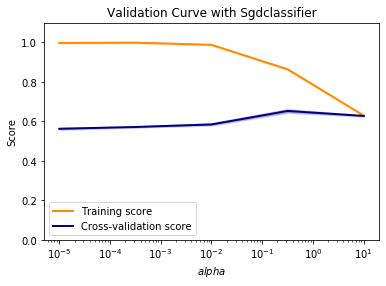

In [270]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [273]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
#print('Confusion matrix for the model is:')
#plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,average='weighted')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
#plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive',average='weighted')
print('precision score  for   the model is: %s'% precisionscore)


Accuracy of the model at optimal hyperparameter alpha = 1.000000% is:  66.875000%
f1 score value for   the model is: 0.5821638797212622
precision score  for   the model is: 0.6034604493045796
Accuracy of the model at optimal hyperparameter alpha = 1.000000% is:  72.232143%
f1 score value for   the model is: 0.6582789750424943
precision score  for   the model is: 0.7455269588213692


In [274]:
#Using Randomized Search CV to find best parameters
# Load libraries
from scipy.stats import uniform

# Create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.8893780319169973, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model :  0.67375
The optimal value of alpha(1/C) is :  0.8893780319169973


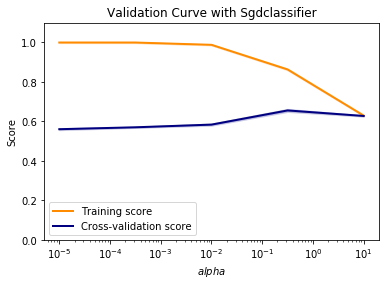

In [275]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [276]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
#print('Confusion matrix for the model is:')
#plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,average='weighted')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
#plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,average='weighted')
print('precision score  for   the model is: %s'% precisionscore)

Accuracy of the model at optimal hyperparameter alpha = 0.889378% is:  67.208333%
f1 score value for   the model is: 0.5891677298064721
precision score  for   the model is: 0.6088385335265999
Accuracy of the model at optimal hyperparameter alpha = 0.889378% is:  73.071429%
f1 score value for   the model is: 0.6723230420749017
precision score  for   the model is: 0.7497879292917029


In [277]:
#[7.2.5] TF-IDF
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)


the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (5600, 1996)
the number of unique words : 1996


In [278]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model :  0.6625
The optimal value of alpha(1/C) is :  1


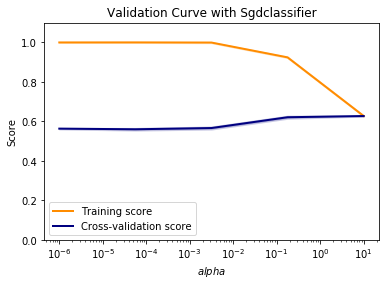

In [279]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-6, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [370]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
#print('Confusion matrix for the model is:')
#plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,average='weighted')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
#plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,average='weighted')
print('precision score  for   the model is: %s'% precisionscore)

TypeError: '<' not supported between instances of 'list' and 'float'

In [281]:
#RandomizedSearchCV Implementation
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.6923688897025195, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model :  0.6670833333333334
The optimal value of alpha(1/C) is :  0.6923688897025195


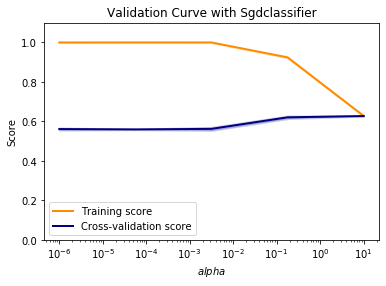

In [282]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-6, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="f1_micro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Sgdclassifier")
plt.xlabel("$alpha$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Accuracy of the model at optimal hyperparameter alpha = 0.692369% is:  66.625000%
Confusion matrix for the model is:


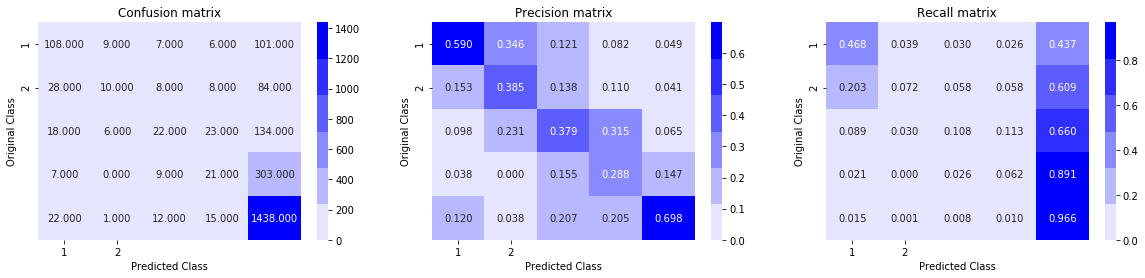

f1 score value for   the model is: 0.5884660875788188
precision score  for   the model is: 0.5845515377996312


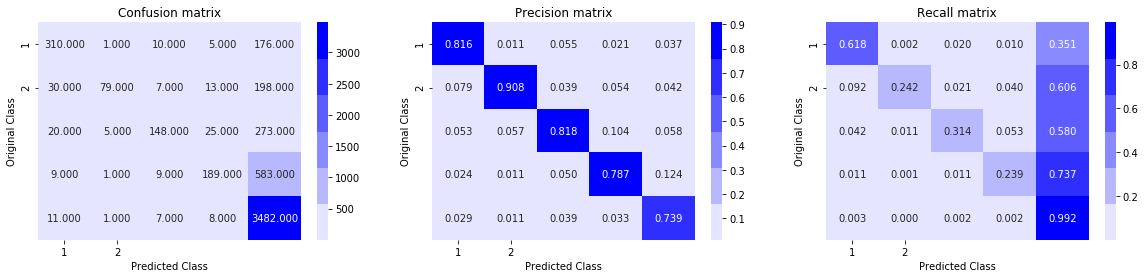

Accuracy of the model at optimal hyperparameter alpha = 0.692369% is:  75.142857%
f1 score value for   the model is: 0.7060683778879062
precision score  for   the model is: 0.7692005023994095


In [283]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive',average='weighted')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive',average='weighted')
print('precision score  for   the model is: %s'% precisionscore)

In [371]:
from prettytable import PrettyTable

# Names of models
featurization = ['Bag of Words ','Bag of Words','Tf-Idf ',\
                 'Tf-Idf ']


# Testing accuracies
accuracy = [66.87,67.20,66.98,66.625,]
F1score = [0.5821,0.5821,0.5881,0.588]
precision=[0.6034,0.6088,0.6022,0.584]
alpha=[0.10,0.16,0.10,0.08]
numbering = [1,2,3,4]
method=['gridsearch','randomsearch','gridsearch','randomsearch']
scoring=['f1_micro','f1_micro','f1_micro','f1_micro']
# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",featurization)
ptable.add_column("method",method)
ptable.add_column("scoring",scoring)
ptable.add_column("accuracy",accuracy)
ptable.add_column("F1 score",F1score)
ptable.add_column("precision",precision)

# Printing the Table
print(ptable)

+-------+---------------+--------------+----------+----------+----------+-----------+
| S.NO. |     MODEL     |    method    | scoring  | accuracy | F1 score | precision |
+-------+---------------+--------------+----------+----------+----------+-----------+
|   1   | Bag of Words  |  gridsearch  | f1_micro |  66.87   |  0.5821  |   0.6034  |
|   2   |  Bag of Words | randomsearch | f1_micro |   67.2   |  0.5821  |   0.6088  |
|   3   |    Tf-Idf     |  gridsearch  | f1_micro |  66.98   |  0.5881  |   0.6022  |
|   4   |    Tf-Idf     | randomsearch | f1_micro |  66.625  |  0.588   |   0.584   |
+-------+---------------+--------------+----------+----------+----------+-----------+


In [284]:
#K-Means++ and K-medoids


In [285]:
my_final = final[:10000]
my_final.sort_values('Time',inplace=True) 

x = my_final['CleanedText'].values

In [286]:
#Implementing K-Means++ and K-medoids
#Bag of Words (BoW)

count_vect = CountVectorizer(min_df = 10) 
data = count_vect.fit_transform(x)
print("the type of count vectorizer :",type(data))
print("the shape of out text BOW vectorizer : ",data.get_shape())
print("the number of unique words :", data.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (8000, 2406)
the number of unique words : 2406


In [287]:
#K-Means++ Implementation

from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

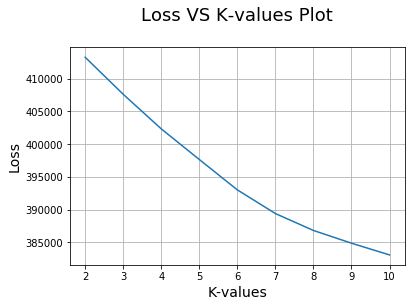

In [288]:
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [289]:
optimal_k = 4
# Variable that will be used in the conclusion 
bow_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

In [290]:
reviews = my_final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  202

No. of reviews in Cluster-2 :  167

No. of reviews in Cluster-3 :  1137

No. of reviews in Cluster-4 :  6494


In [291]:
#reading reviews manually
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 The grapefruit and blackberry flavors are the current favorite at my house on Tuesday nights when we try to always have a rotisserie chicken and homemade gravy while watching TV.<br /><br />Once you taste the subtle fruit flavors mingling perfectly in a not overly carbonated sparkling water, you may want to order this by the case.<br /><br />There are no artificial flavorings or colorings, not to mention extra sugar. The only sweetener is grape juice and apple juice concentrate. Lemon juice and fruit concentrates mingle with the sparkling water to create a delicate, smooth, slightly tingly and delicious drink.<br /><br />Perfect for drinking with dinner or taking along on a picnic.<br /><br />~The Rebecca Review

Review-2 : 
 I'm not much of a soda drinker, but I enjoy a good natural fruit soda in the summertime. Izze describes their sodas as "100% Pure Fruit Juice and Sparkling Water". That's an exaggeration, as there are a few more natural ingredients beside fruit juice 

In [292]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 Cat Grass is not only a treat that cats love to eat, it is also good for them and will help deter them away from eating houseplants!  My cat often nibbles on houseplants then throws up and I'm always afraid that it will do damage to her digestive system.  When there is cat grass around, though, she only eats that - she really chows it down, and it makes her happy, too!  Cat grass is also good for cats - it contains vitamins that may or may not be present in cat food, and it aids their digestive system and helps to eliminate fur balls.<br /><br />Even if you do not have a green thumb, cat grass is so easy to grow, that anyone can do it and it's also a great "project" for kids, too.  The seeds sprout very quickly (if you keep them moist) and will grow quickly to 4-6inches in a window sill.<br /><br />If you have cats, cat grass is a must!

Review-2 : 
 As I get older and fatter, I seek opportunities to eat snacks that at least make a nominal attempt to be healthy.  Oreo cook

In [293]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 Once or twice a year for a little variety and that's about enough for my cat of this particular variety.  He likes it for a change from his chicken, turkey and beef, but not very often.  He will eat about 3/4 of the can and then he's had enough. He's not a huge fish fan anyway, but this stuff looks to be about the best out there in the fish varieties.  The chunks are bit sized so if your cat has a small mouth like mine does, it will be easier to chew.  Don't know why my cat doesn't like this type of fish, but he really could care less about it.

Review-2 : 
 This version is ground.  NOt my current cat's favorite version, but he really likes the taste. I do wish they'd make this one not ground but in the pieces variety too.  My previous cat really liked this one and usually licked the bowl clean. But, neither wanted it more than once or twice a month.  Why, I don't know but it seems to be a little richer than the others.

Review-3 : 
 Buy these cookies. You will not regret 

In [294]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!

Review-2 : 
 I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.

Review-3 : 
 Mae Ploy Sweet Chili Sauce is becoming a standard condiment on my dinner table. It has just the right blend of sweet and heat; Mae Ploy enhances the taste of all meat and fish foods. Catsup is almost a condiment of the past. Salsa and Mae Ploy are the answers!



In [295]:
#K-Medoids Implementation

def print_cluster_reviews_k_medoids(cluster_label_reviews,cluster_number = 0,review_count=3):
    reviews = cluster_label_reviews[cluster_number]
    reviews = reviews[0:review_count]
    print("---: Cluster {0} :---".format(cluster_number))
    index = 1
    for review in reviews:
        print("Review {0} : ".format(index))
        print(CLEANED_TEXT[review])
        print()
        index += 1

In [296]:
def get_cluster_N_medoids(k_medoids):
    return k_medoids.get_clusters(),k_medoids.get_medoids()

In [297]:
from sklearn.decomposition import TruncatedSVD
#from pyclustering.utils import calculate_distance_matrix
#from pyclustering.cluster import kmedoids

svd = TruncatedSVD(n_components=2)
bow_dtm_2_dim = svd.fit_transform(data)
bow_dtm_2_dim.shape

(8000, 2)

In [298]:
from pyclustering.cluster import kmedoids
k_medoids = kmedoids.kmedoids(bow_dtm_2_dim,[2, 9, 12],0.001,ccore=True)
# Run cluster analysis and obtain results
k_medoids.process()

In [299]:
clusters,medoids = get_cluster_N_medoids(k_medoids)

In [300]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices)))

Number of Reviews in Cluster 0 : 5265 
Number of Reviews in Cluster 1 : 502 
Number of Reviews in Cluster 2 : 2233 


In [301]:
CLEANED_TEXT = my_final['Text'].values

In [302]:
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
I ordered this for my Mother-in-law who could not find this product anywhere near where she lives.  She is really enjoying this product.

Review 2 : 
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!

Review 3 : 
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.




---: Cluster 1 :---
Review 1 : 
I'm not sure how you review something that's as subjective as taste, but suffice to say that if you like chocolate and graha

In [303]:
#TFIDF

tf_idf_vect = TfidfVectorizer(min_df=10)
data = tf_idf_vect.fit_transform(x)
print("the type of count vectorizer :",type(data))
print("the shape of out text TFIDF vectorizer : ",data.get_shape())
print("the number of unique words :", data.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (8000, 2406)
the number of unique words : 2406


In [304]:
from sklearn.cluster import KMeans
k_values = [2,3,4,5,6,7,8,9]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

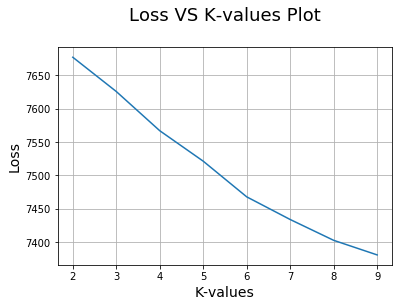

In [305]:
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [306]:
reviews = my_final['Text'].values
optimal_k = 6
# Variable that will be used in the conclusion 
tfidf_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])    
    else :
        cluster6.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))


No. of reviews in Cluster-1 :  524

No. of reviews in Cluster-2 :  524

No. of reviews in Cluster-3 :  5538

No. of reviews in Cluster-4 :  417

No. of reviews in Cluster-5 :  339

No. of reviews in Cluster-6 :  658


In [307]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 This one is a great basic food. Whatever is in it, cats really go for and mine is no exception.  My current cat really doesn't like the ground variety which is what this is.  He will eat it occasionally, so I only buy it about twice a year.  My previous cat had to have it more often and really enjoyed it.  It's hard to judge what a cat will eat so if your cat likes ground, give this one a go because it really seems to be a big favorite.

Review-2 : 
 This is my cat's third favorite food.  It's great stuff - the gravy is so very thick and the food looks like bits of steak slicked off for your friend.  My cat licks the bowl clean every time and wants more.  They should send me discounts for as much of this stuff I buy.  I buy it by the case if that gives you some idea!

Review-3 : 
 This is my cat's favorite one.  He just licks that bowl clean whenever he gets it.  I usually buy a case of this one at a time and judging from how often it sells out, other cats must love it too

In [308]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 I found these tubs at Costco and was dismayed to discover that they are no longer carrying them. I buy the 4-pack here at amazon and I am very satisfied. The snacks are tasty; not too salty and offers a variety of chips in the mix that all blend nicely.

Review-2 : 
 I can't believe how wonderful this chip is! The slightly spicy after taste gives the chip extra punch and flavor. My family and I are offically addicted.

Review-3 : 
 Slightly crumbly, but overall a very good cookie.  In my opinion very similar to Chips Ahoy but more airy, less dense.



In [309]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!

Review-2 : 
 I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.

Review-3 : 
 Mae Ploy Sweet Chili Sauce is becoming a standard condiment on my dinner table. It has just the right blend of sweet and heat; Mae Ploy enhances the taste of all meat and fish foods. Catsup is almost a condiment of the past. Salsa and Mae Ploy are the answers!



In [310]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 Sleepytime is a popular tea that has been around a long time due to its high quality. The natural flavors and ingredients have made it a required tea for the cupboard of persons interested in healthy eating for the last 30 years! The predominant flavors are of chamomile and spearmint--but the additional ingredients--including rose buds--create a satisfying, complex blend that is very tasty and soothing. Not only is Sleepytime caffeine-free but it contains herbs that are mildly relaxing and healing for the stomach. Drink this lovely tea before bed either with or without honey.<br /><br />Sleepytime contains chamomile, spearmint, lemongrass, tilia flowers, blackberry leaves, orange blossoms, hawthorne berries and rosebuds. The healing qualities of some the herbs in Sleepytime are listed below, however please note that there is insufficient quantities of each herb to have anything more than a very mild effect. Blackberry leaves, which are soothing to the stomach, contain tann

In [311]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    count +=1

Review-1 : 
 Too much of the white pith on this orange peel making the product overly bitter and diluting the real good taste of the orange zest.

Review-2 : 
 Too much of the white pith on this orange peel making the product overly bitter and diluting the real good taste of the orange zest.

Review-3 : 
 Too much of the white pith on this orange peel making the product overly bitter and diluting the real good taste of the orange zest.



In [312]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster6[i]))
    count +=1

Review-1 : 
 This is the coffee we crave in our house. It is a strong brew, yet not bitter. Yuban is the best ground coffee we have tasted, yet.

Review-2 : 
 First, Yuban is my favorite coffee. To be able to buy a case and save is great. The coffee was in date, the seals on the cans were excellent, and the freshness of the coffee was excellent. I will definitely buy more Yuban coffee when I need it from Amazon groceries.

Review-3 : 
 I am a true Seattle coffee addict, and I have never had a better coffee candy.



In [313]:
#k-mediods
from sklearn.decomposition import TruncatedSVD
from pyclustering.utils import calculate_distance_matrix
from pyclustering.cluster import kmedoids

In [314]:
def print_cluster_reviews_k_medoids(cluster_label_reviews,cluster_number = 0,review_count=3):
    reviews = cluster_label_reviews[cluster_number]
    reviews = reviews[0:review_count]
    print("---: Cluster {0} :---".format(cluster_number))
    index = 1
    for review in reviews:
        print("Review {0} : ".format(index))
        print(CLEANED_TEXT[review])
        print()
        index += 1

In [315]:
def get_cluster_N_medoids(k_medoids):
    return k_medoids.get_clusters(),k_medoids.get_medoids()

In [316]:
svd = TruncatedSVD(n_components=2)
tfidf_dtm_2_dim = svd.fit_transform(data)
tfidf_dtm_2_dim.shape

(8000, 2)

In [317]:
k_medoids = kmedoids.kmedoids(tfidf_dtm_2_dim,[2, 9, 12],0.001,ccore=True)
# Run cluster analysis and obtain results
k_medoids.process()

In [318]:
clusters,medoids = get_cluster_N_medoids(k_medoids)

In [319]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices)))

Number of Reviews in Cluster 0 : 4208 
Number of Reviews in Cluster 1 : 2308 
Number of Reviews in Cluster 2 : 1484 


In [320]:
CLEANED_TEXT = my_final['Text'].values

In [321]:
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
Bought these for a change from the green split peas. They are tasty and I like them. Will buy again. Always like Bob's Red Mill products.

Review 2 : 
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!

Review 3 : 
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.




---: Cluster 1 :---
Review 1 : 
When I first found out that my 4 year old I had to go Gluten free I was a little worried about how she would handle it. GF 

In [322]:
from prettytable import PrettyTable

names = ['K-means++ for BoW','K-medoids for BoW','K-means++ for TFIDF','K-medoids for TFIDF']

optimal_k = [4,3,6,3]

numbering = [1,2,3,4]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_k)

# Printing the Table
print(table)

+-------+---------------------+---------------------+
| S.NO. |        MODEL        | Number of Clusters  |
+-------+---------------------+---------------------+
|   1   |  K-means++ for BoW  |          4          |
|   2   |  K-medoids for BoW  |          3          |
|   3   | K-means++ for TFIDF |          6          |
|   4   | K-medoids for TFIDF |          3          |
+-------+---------------------+---------------------+


In [323]:
#Naive Bayes


final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


In [324]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [325]:
count_vect = CountVectorizer(min_df = 10) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (5600, 1996)
the number of unique words : 1996


In [326]:
# Importing libraries
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

# Creating alpha values in the range from 10^-3 to 10^3
neighbors = []
i = 0.001
while(i<=1000):
    neighbors.append(np.round(i,3))
    i *= 3

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    bn = MultinomialNB(alpha = k)
    scores = cross_val_score(bn, X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# determining best value of alpha
optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)   


The optimal value of alpha is 6.561.


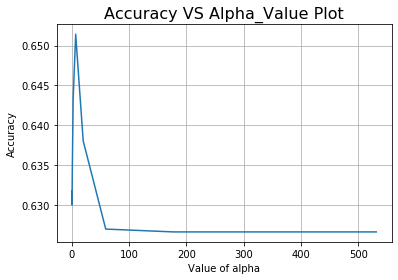



Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

Accuracy for each alpha value is :
  [0.63054 0.63179 0.63143 0.63161 0.63    0.63089 0.63464 0.64339 0.65143
 0.63804 0.62696 0.62661 0.62661]


In [327]:
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",neighbors)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [328]:
bn_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
bn_optimal.fit(X_train_vec, Y_train)

# predict the response
predictions = bn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_multinomial_alpha = optimal_alpha
bow_multinomial_train_acc = max(cv_scores)*100
bow_multinomial_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 6.561 is 64.875000%


In [329]:
bn_optimal.classes_

array([1, 2, 3, 4, 5], dtype=int64)

In [330]:
# Now we can find log probabilities of different features for both the classes
class_features = bn_optimal.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))    

Top 20 Important Features and their log probabilities For Negative Class :


not	 -->	-4.141136  
like	 -->	-4.819668  
tast	 -->	-4.835139  
product	 -->	-4.850853  
tri	 -->	-5.153747  
would	 -->	-5.208839  
one	 -->	-5.261158  
food	 -->	-5.285319  
use	 -->	-5.480488  
buy	 -->	-5.487947  
flavor	 -->	-5.495462  
order	 -->	-5.510665  
eat	 -->	-5.565770  
even	 -->	-5.582089  
time	 -->	-5.598679  
good	 -->	-5.607078  
get	 -->	-5.615548  
amazon	 -->	-5.686024  
dont	 -->	-5.713788  
make	 -->	-5.781735  


Top 20 Important Features and their log probabilities For Positive Class :


not	 -->	-4.406291  
tast	 -->	-4.780190  
like	 -->	-4.784734  
flavor	 -->	-5.188922  
product	 -->	-5.209604  
one	 -->	-5.367755  
good	 -->	-5.426565  
use	 -->	-5.426565  
tri	 -->	-5.426565  
drink	 -->	-5.470797  
would	 -->	-5.545906  
much	 -->	-5.670340  
get	 -->	-5.681444  
make	 -->	-5.762826  
juic	 -->	-5.787349  
food	 -->	-5.838276  
buy	 -->	-5.838276  
sugar	 -->	-5.878249  
wate

In [331]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive',average='weighted') 
print('\nThe Test Precision of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive',average='weighted')
print('\nThe Test Recall of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive',average='weighted')
print('\nThe Test F1-Score of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))



The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 6.561 is 64.875000%

The Test Precision of the Multinomial naive Bayes classifier for alpha = 6.561 is 0.568277

The Test Recall of the Multinomial naive Bayes classifier for alpha = 6.561 is 0.648750

The Test F1-Score of the Multinomial naive Bayes classifier for alpha = 6.561 is 0.592080


In [332]:
# Code for drawing seaborn heatmaps
#class_names = ['negative','positive']
#df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
#fig = plt.figure(figsize=(10,7))
#heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#plt.ylabel('Predicted label',size=18)
#plt.xlabel('True label',size=18)
#plt.title("Confusion Matrix\n",size=24)
#plt.show()

In [333]:
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (5600, 1996)
the number of unique words : 1996


In [334]:
# Creating alpha values in the range from 10^-3 to 10^3
neighbors = []
i = 0.001
while(i<=1000):
    neighbors.append(np.round(i,3))
    i *= 3

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    bn = MultinomialNB(alpha = k)
    scores = cross_val_score(bn, X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# determining best value of alpha
optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.081.


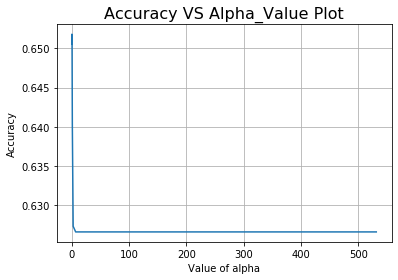



Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

Accuracy for each alpha value is :
  [0.65054 0.65161 0.65125 0.65179 0.65179 0.65    0.64018 0.62732 0.62661
 0.62661 0.62661 0.62661 0.62661]


In [335]:
# plot accuracy vs alpha 
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",neighbors)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [336]:
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ==============================================
# instantiate learning model alpha = optimal_alpha
bn_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
bn_optimal.fit(X_train_vec, Y_train)

# predict the response
predictions = bn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_multinomial_alpha = optimal_alpha
tfidf_multinomial_train_acc = max(cv_scores)*100
tfidf_multinomial_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.081 is 65.208333%


In [337]:
bn_optimal.classes_

array([1, 2, 3, 4, 5], dtype=int64)

In [338]:
# Now we can find log probabilities of different features for both the classes
class_features = bn_optimal.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))    

Top 20 Important Features and their log probabilities For Negative Class :


not	 -->	-4.348797  
tast	 -->	-4.872224  
product	 -->	-4.885766  
like	 -->	-4.942006  
would	 -->	-5.187617  
tri	 -->	-5.254155  
order	 -->	-5.345365  
even	 -->	-5.355095  
disappoint	 -->	-5.366358  
buy	 -->	-5.376213  
one	 -->	-5.387385  
food	 -->	-5.422890  
flavor	 -->	-5.517160  
eat	 -->	-5.518309  
dont	 -->	-5.547883  
get	 -->	-5.551828  
box	 -->	-5.557673  
tea	 -->	-5.599638  
use	 -->	-5.604971  
item	 -->	-5.606040  


Top 20 Important Features and their log probabilities For Positive Class :


not	 -->	-4.481591  
tast	 -->	-4.688971  
like	 -->	-4.801147  
product	 -->	-5.109593  
flavor	 -->	-5.131915  
drink	 -->	-5.207848  
tri	 -->	-5.224336  
would	 -->	-5.286671  
one	 -->	-5.361550  
good	 -->	-5.390990  
use	 -->	-5.396413  
juic	 -->	-5.459892  
much	 -->	-5.540440  
tea	 -->	-5.542983  
orang	 -->	-5.560375  
get	 -->	-5.592415  
buy	 -->	-5.593757  
water	 -->	-5.630650  
su

In [339]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions,average='weighted') 
print('\nThe Test Precision of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions,average='weighted')
print('\nThe Test Recall of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions,average='weighted')
print('\nThe Test F1-Score of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))



The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.081 is 65.208333%

The Test Precision of the Multinomial naive Bayes classifier for alpha = 0.081 is 0.588972

The Test Recall of the Multinomial naive Bayes classifier for alpha = 0.081 is 0.652083

The Test F1-Score of the Multinomial naive Bayes classifier for alpha = 0.081 is 0.560796


In [340]:
# Code for drawing seaborn heatmaps
#class_names = ['negative','positive']
#df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
#fig = plt.figure(figsize=(10,7))
#heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#plt.ylabel('Predicted label',size=18)
#plt.xlabel('True label',size=18)
#plt.title("Confusion Matrix\n",size=24)
#plt.show()

In [341]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["MultinomialNB for BoW", "MultinomialNB for TFIDF"]

optimal_alpha = [bow_multinomial_alpha, tfidf_multinomial_alpha]

train_acc = [bow_multinomial_train_acc, tfidf_multinomial_train_acc]

test_acc = [bow_multinomial_test_acc,  tfidf_multinomial_test_acc]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_alpha)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-------------------------+------------+-------------------+-------------------+
| S.NO. |          MODEL          | Best Alpha | Training Accuracy |   Test Accuracy   |
+-------+-------------------------+------------+-------------------+-------------------+
|   1   |  MultinomialNB for BoW  |   6.561    | 65.14285714285715 |       64.875      |
|   2   | MultinomialNB for TFIDF |   0.081    | 65.17857142857143 | 65.20833333333333 |
+-------+-------------------------+------------+-------------------+-------------------+


In [342]:
#logistic Regression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)

X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)
print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape)

Test Data Size:  (2400, 12378)
Train Data Size:  (5600, 12378)


In [343]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(510, 12378) (509, 12378)
(1019, 12378) (509, 12378)
(1528, 12378) (509, 12378)
(2037, 12378) (509, 12378)
(2546, 12378) (509, 12378)
(3055, 12378) (509, 12378)
(3564, 12378) (509, 12378)
(4073, 12378) (509, 12378)
(4582, 12378) (509, 12378)
(5091, 12378) (509, 12378)


In [344]:
#GridSearchCV
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
#savetofile(gsv,"Log Reg/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  5.5min finished


Best HyperParameter:  {'C': 0.005, 'penalty': 'l2'}
Best Accuracy: 63.28%


In [364]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,classification_report
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
clf = LogisticRegression(C= 0.005, penalty= 'l2')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred,average='weighted')))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred,average='weighted')))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")

Accuracy on train set: 99.679%
Precision on train set: 0.997
Recall on train set: 0.997
F1-Score on train set: 0.997
Non Zero weights: 61890
Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



In [365]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='weighted')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='weighted')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
#print('Confusion matrix for the model is:')

Accuracy on test set: 58.458%
Precision on test set: 0.514
Recall on test set: 0.585
F1-Score on test set: 0.534
Non Zero weights: 61890
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



In [349]:
#Using Randomized Search CV to find best parameters
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
#savetofile(gsv,"Log Reg/gsv_uni_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.0min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 0.01}
Best Accuracy: 63.24%


In [351]:
clf = LogisticRegression(C= 0.0001, penalty= 'l2')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred,average='weighted')))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred,average='weighted')))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
#plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='weighted')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='weighted')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")

Accuracy on train set: 73.875%
Precision on train set: 0.815
Recall on train set: 0.739
F1-Score on train set: 0.739
Non Zero weights: 61890
Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 60.917%
Precision on test set: 0.468
Recall on test set: 0.609
F1-Score on test set: 0.468
Non Zero weights: 61890
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



In [352]:
#Bi-Grams
#Now that we have our list of words describing positive and negative reviews lets analyse them.
#We begin analysis by getting the frequency distribution of the words as shown below
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)

X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)
print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (5600, 141281)
Test Data Size:  (2400, 141281)


In [353]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
#param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
param_grid = {'C':[1000,100,10,0.01],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
#savetofile(gsv,"Log Reg/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 16.6min finished


Best HyperParameter:  {'C': 100, 'penalty': 'l2'}
Best Accuracy: 62.75%


In [354]:
clf = LogisticRegression(C= 0.01, penalty= 'l2')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred,average='weighted')))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred,average='weighted')))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
#plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='weighted')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='weighted')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


Accuracy on train set: 100.000%
Precision on train set: 1.000
Recall on train set: 1.000
F1-Score on train set: 1.000
Non Zero weights: 706405
Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 61.000%
Precision on test set: 0.519
Recall on test set: 0.610
F1-Score on test set: 0.463
Non Zero weights: 706405
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



In [355]:
#Using Randomized Search CV to find best parameters
#We can see how drastically the sparsity decreases from 467782 non-zero 
#weights(@ C=1000) to only 25153 non-zero weights(@ C=0.01) when we use L1 Regularization
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
#savetofile(gsv,"Log Reg/gsv_bi_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.3min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 0.0005}
Best Accuracy: 62.75%


In [356]:
clf = LogisticRegression(C= 0.01, penalty= 'l2')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred,average='weighted')))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred,average='weighted')))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='weighted')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='weighted')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")



Accuracy on train set: 100.000%
Precision on train set: 1.000
Recall on train set: 1.000
F1-Score on train set: 1.000
Non Zero weights: 706405
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 61.000%
Precision on test set: 0.519
Recall on test set: 0.610
F1-Score on test set: 0.463
Non Zero weights: 706405
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



In [357]:

%%time
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer() 
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)

X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)





Train Data Size:  (5600, 12378)
Test Data Size:  (2400, 12378)
Wall time: 871 ms


In [358]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  5.6min finished


Best HyperParameter:  {'C': 0.01, 'penalty': 'l2'}
Best Accuracy: 63.28%


In [366]:
clf = LogisticRegression(C= 0.05, penalty= 'l2')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred,average='weighted')))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred,average='weighted')))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='weighted')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='weighted')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


Accuracy on train set: 100.000%
Precision on train set: 1.000
Recall on train set: 1.000
F1-Score on train set: 1.000
Non Zero weights: 61890
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 56.708%
Precision on test set: 0.515
Recall on test set: 0.567
F1-Score on test set: 0.533
Non Zero weights: 61890
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



In [360]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 53.833%
F1-Score on test set: 0.538
Non Zero weights: 61890


In [361]:
#Regularization Using Randomized Search CV to find best parameters
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))




Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 0.01}
Best Accuracy: 63.28%


In [362]:
clf = LogisticRegression(C= 0.05, penalty= 'l2')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred,average='weighted')))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred,average='weighted')))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='weighted')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='weighted')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='weighted')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


Accuracy on train set: 100.000%
Precision on train set: 1.000
Recall on train set: 1.000
F1-Score on train set: 1.000
Non Zero weights: 61890
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 56.708%
Precision on test set: 0.515
Recall on test set: 0.567
F1-Score on test set: 0.533
Non Zero weights: 61890
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



In [363]:
from prettytable import PrettyTable

# Names of models
featurization = ['Bag of Words','Bag of Words','bigram','bigram','td','td']
model=['gridsearch ','randomsearch','gridsearch ','randomsearch','gridsearch ','randomsearch']

# Training accuracies
F1score= [0.536,0.468,0.463,0.463,0.533,0.533]
accuracy = [56.417,60.917,61.00,61.00,56.708,56.708]
alpha=[0.05,0.001,0.01,0.01,0.01,0.01]
precision=[0.523,0.468,0.610,0.610,0.567,0.567]
recall=[0.564,0.609,0.463,0.463,0.533,0.533]
numbering = [1,2,3,4,5,6]
regularization=['l2','l2','l2','l2','l2','l2']

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",featurization)
ptable.add_column("Method",model)
ptable.add_column("C",alpha)
ptable.add_column("regularization",regularization)
ptable.add_column("accuracy",accuracy)
ptable.add_column("f1score",F1score)
ptable.add_column("precision",precision)
ptable.add_column("recall",recall)


# Printing the Table
print(ptable)

+-------+--------------+--------------+-------+----------------+----------+---------+-----------+--------+
| S.NO. |    MODEL     |    Method    |   C   | regularization | accuracy | f1score | precision | recall |
+-------+--------------+--------------+-------+----------------+----------+---------+-----------+--------+
|   1   | Bag of Words | gridsearch   |  0.05 |       l2       |  56.417  |  0.536  |   0.523   | 0.564  |
|   2   | Bag of Words | randomsearch | 0.001 |       l2       |  60.917  |  0.468  |   0.468   | 0.609  |
|   3   |    bigram    | gridsearch   |  0.01 |       l2       |   61.0   |  0.463  |    0.61   | 0.463  |
|   4   |    bigram    | randomsearch |  0.01 |       l2       |   61.0   |  0.463  |    0.61   | 0.463  |
|   5   |      td      | gridsearch   |  0.01 |       l2       |  56.708  |  0.533  |   0.567   | 0.533  |
|   6   |      td      | randomsearch |  0.01 |       l2       |  56.708  |  0.533  |   0.567   | 0.533  |
+-------+--------------+-------------